In [1]:
from random import uniform
from time import time
import numpy as np

def throw_dart(ndarts):
    nin = 0
    for n in range(ndarts):
        x,y = uniform(0,1), uniform(0,1)
        if np.sqrt((x-0.5)**2 + (y-0.5)**2) <= 0.5:
            nin += 1
#    print(4*float(nin)/float(ndarts))
    return 4*float(nin)/float(ndarts)

#check to make sure it works
'''f, me = throw_dart(10_000_000)
print("Pi approx", f)
print("Pi time", me)
'''

'f, me = throw_dart(10_000_000)\nprint("Pi approx", f)\nprint("Pi time", me)\n'

In [24]:
#raw no parallelism (UGH)
dart_numbers = [i for j in (range(1,999,50), range(1_000,19_001,1_000), range(20_000, 10_000_001, 500_000))
                for i in j]

t_t = time()
simp_ndarts = []
simp_runtimes = []
simp_pi_approx = []

for i in dart_numbers:
    start = time()
    nin = throw_dart(i)
    simp_ndarts.append(i)
    simp_pi_approx.append(nin)
    simp_runtimes.append(time() - start)    

print(time() - t_t)

250.63370370864868


In [5]:
import multiprocessing, math

mult_ndarts = []
mult_runtimes = []

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=4)
    for i in dart_numbers:
        start = time()
        
        chunksize=20_000
        if(i <= 20_000):
            chunksize = 1000
        if(i <= 1_000):
            chunksize = 50
        n_iter = math.ceil(i/chunksize)
        
        dart_array = np.repeat(chunksize,n_iter)
        ans = list(pool.map(throw_dart, dart_array))
        
        mult_ndarts.append(sum(dart_array))
        mult_runtimes.append(time()- start)
        
    del pool

In [6]:
from distributed import Client

dask_ndarts = []
dask_runtimes = []

if __name__ == '__main__':
    for i in dart_numbers:
        start = time()
        e = Client(processes=False)
        
        chunksize=20_000
        if(i <= 20_000):
            chunksize = 1000
        if(i <= 1_000):
            chunksize = 50
        n_iter = math.ceil(i/chunksize)
        
        dart_array = np.repeat(chunksize,n_iter)
        
        futures = e.map(throw_dart, dart_array)
        ans = list(e.gather(futures))
        dask_ndarts.append(sum(dart_array))
        dask_runtimes.append(time()- start)
        
        e.close()
        print(time()- start)

0.057219505310058594
0.05037975311279297
0.032904624938964844
0.03259110450744629
0.03168344497680664
0.03800249099731445
0.05000424385070801
0.04174447059631348
0.10248160362243652
0.03645491600036621
0.0516204833984375
0.06148505210876465
0.05365872383117676
0.04719209671020508
0.07196998596191406
0.060915231704711914
0.05755257606506348
0.061577796936035156
0.07747745513916016
0.07163000106811523
0.08602046966552734
0.10918402671813965
0.07462644577026367
0.07881903648376465
0.12593483924865723
0.10564684867858887
0.12104392051696777
0.12693548202514648
0.1311349868774414
0.1780991554260254
0.19207453727722168
0.16185259819030762
0.2573986053466797
0.2567777633666992
0.45388317108154297
0.9853808879852295
0.8078038692474365
0.5313727855682373
0.49855780601501465
0.4737052917480469
0.6144180297851562
0.6710364818572998
0.7178487777709961
0.801093339920044
0.8552532196044922
0.9260756969451904
0.9490489959716797
1.0342199802398682
2.5980663299560547
2.317744016647339
1.656976461410522

[None, None, None, None, None]

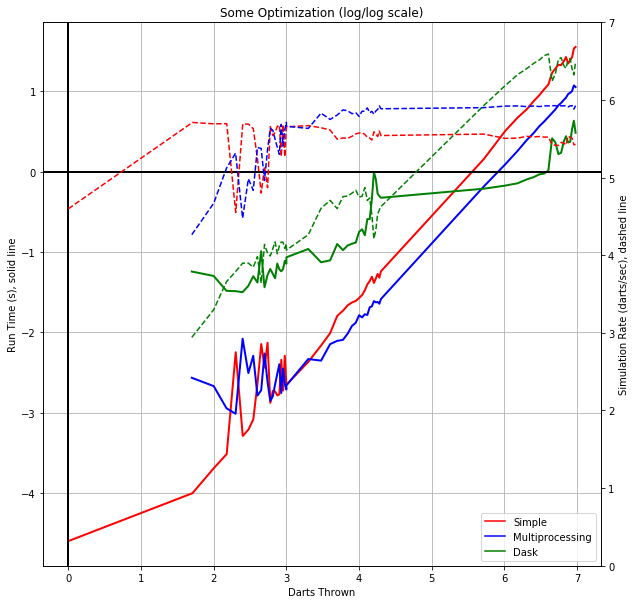

In [23]:
import matplotlib.pyplot as plt
from matplotlib import rc, gridspec, cm

%matplotlib inline
simp_rates = []
for i in range(0,len(simp_ndarts)):
    simp_rates.append(float(simp_ndarts[i]) / float(simp_runtimes[i]))
mult_rates = []
for i in range(0,len(simp_ndarts)):
    mult_rates.append(float(mult_ndarts[i]) / float(mult_runtimes[i]))
dask_rates = []
for i in range(0,len(simp_ndarts)):
    dask_rates.append(float(dask_ndarts[i]) / float(dask_runtimes[i]))

f, ax = plt.subplots(figsize=(10,10))

ax.plot(np.log10(simp_ndarts), np.log10(simp_runtimes), 'r-', label='Simple')
ax.plot(np.log10(mult_ndarts), np.log10(mult_runtimes), 'b-', label='Multiprocessing')
ax.plot(np.log10(dask_ndarts), np.log10(dask_runtimes), 'g-', label='Dask')

ax.grid()
ax.legend(loc='lower right')

ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_frame_on(True)

ax.set_title('Some Optimization (log/log scale)')
ax.set_xlabel('Darts Thrown')
ax.set_ylabel('Run Time (s), solid line')

ax2 = ax.twinx()
ax2.set_ylabel('Simulation Rate (darts/sec), dashed line')
ax2.plot(np.log10(simp_ndarts), np.log10(simp_rates), 'r--')
ax2.plot(np.log10(mult_ndarts), np.log10(mult_rates), 'b--')
ax2.plot(np.log10(dask_ndarts), np.log10(dask_rates), 'g--')
ax2.set_ylim([0,7])
plt.setp(ax.lines, linewidth=2)
